In [12]:
import sys
import os

# Source: https://stackoverflow.com/questions/16780014/import-file-from-parent-directory
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__name__))))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from lusi.svm import SVMRandomInvariants
from lusi.types import InvariantTypes

In [13]:
# Generate datasets
datasets = [
    make_circles(1000, noise=0.1, factor=0.5, random_state=47),
    make_moons(1000, noise=0.05, random_state=47),
]

In [14]:
def plot_datasets(datasets, titles):
    figure = plt.figure(figsize=(12,5))
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    for i in range(len(datasets)):
        X, y = datasets[i]
        plt.subplot(1, 2, i+1)
        plt.title(titles[i])
        plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')
    
    plt.savefig("toy_datasets.png")
    plt.show()

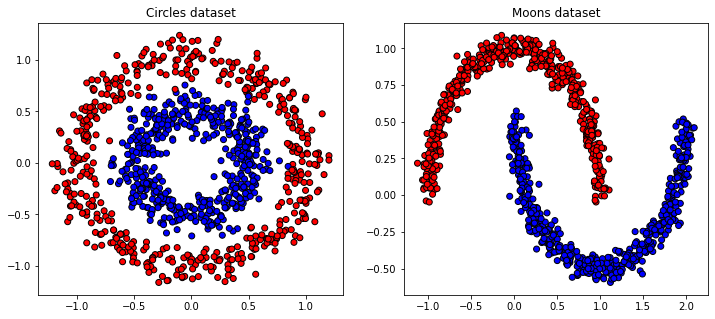

In [15]:
plot_datasets(datasets, ['Circles dataset', 'Moons dataset'])

In [5]:
# Foreach dataset (2 datasets)
# Try C parameter (3-4 values should be enough)
# Test num_invariants paramter (2-4 values should be enough)
# Test tau paramter (2-3 values should be enough)
# Test invariant type

## Testing hyperparameters

In [47]:
def plot_decision_boundary(clf, X, y, ax, title=''):
    h = .02
    x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
    y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    viz=np.c_[xx.ravel(),yy.ravel()]
    Z = clf.predict_proba(viz, clip=False)
    Z = Z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.set_title(title)
    ax.contourf(xx, yy, Z, levels=np.linspace(-1.3,2.3,13), cmap=cm, alpha=.8)
    ax.contour(xx, yy, Z, levels=[0.5], linestyles='dashed')
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')
    plt.tight_layout()

X, y = datasets[0]

In [76]:
def run_experiment_dataset(dataset, seeds, invariant_types, out_file):
    num_invariants = {
        invariant: [] for invariant in invariant_types
    }
    
    X, y = dataset
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=0.1,
        stratify=y,
        random_state=47,
    )
    
    for seed in seeds:
        for invariant_type in invariant_types:
            clf = SVMRandomInvariants(num_invariants=3, invariant_type=invariant_type)
            clf.fit(X_train, y_train)
            num_invariants[invariant_type].append(len(clf.invariants))
    
    mean_invariants = {invariant: np.mean(n_invariants) for invariant, n_invariants in num_invariants.items()}
    
    fig, ax = plt.subplots(len(invariant_types), 2, figsize=(10, 15))

    invariant_names = {
        InvariantTypes.VAPNIK: "Vapnik invariants",
        InvariantTypes.PROJECTION: "random projections",
        InvariantTypes.HYPERPLANE: "random hyperplanes"
    }

    for i, invariant_type in enumerate(invariant_types):
        clf = SVMRandomInvariants(num_invariants=3, invariant_type=invariant_type, random_state=4)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print("Accuracy: ", acc)

        plot_decision_boundary(clf, X_train, y_train, ax[i, 0], f'Decision boundary with training data\nusing {invariant_names[invariant_type]}')
        plot_decision_boundary(clf, X_test, y_test, ax[i, 1], f'Decision boundary with test data\nusing {invariant_names[invariant_type]}')
    
    plt.savefig(out_file)
    plt.show()

    
    return mean_invariants
        

Accuracy:  0.9922222222222222
Accuracy:  0.9922222222222222
Accuracy:  0.9911111111111112


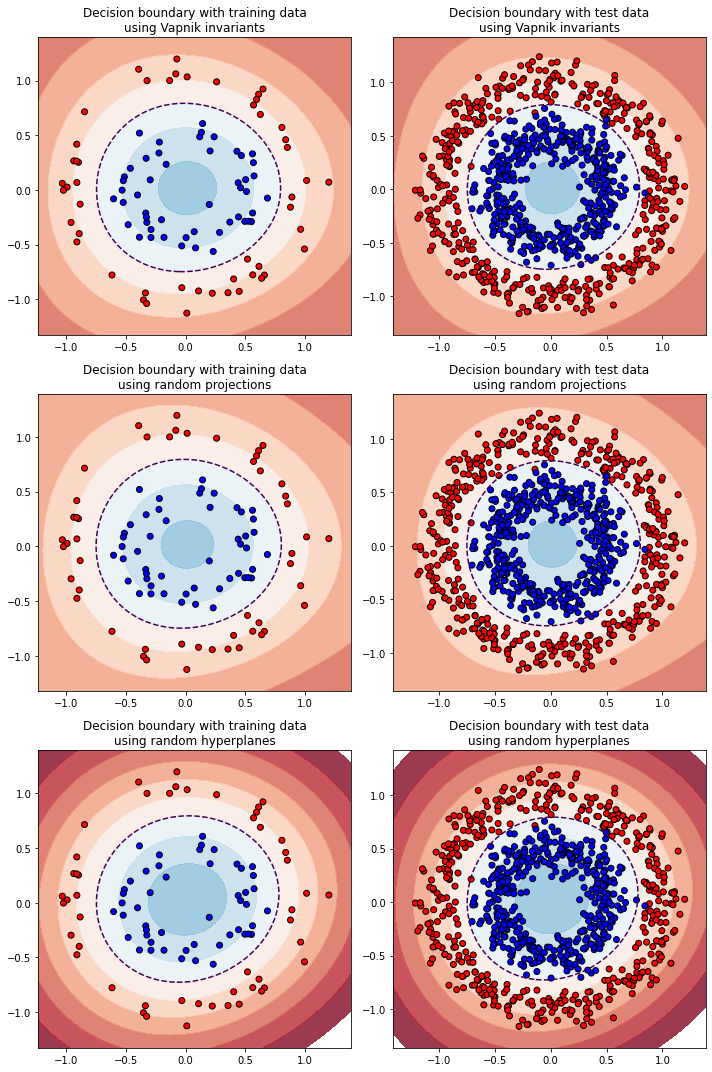

Accuracy:  0.9588888888888889
Accuracy:  0.96
Accuracy:  0.9844444444444445


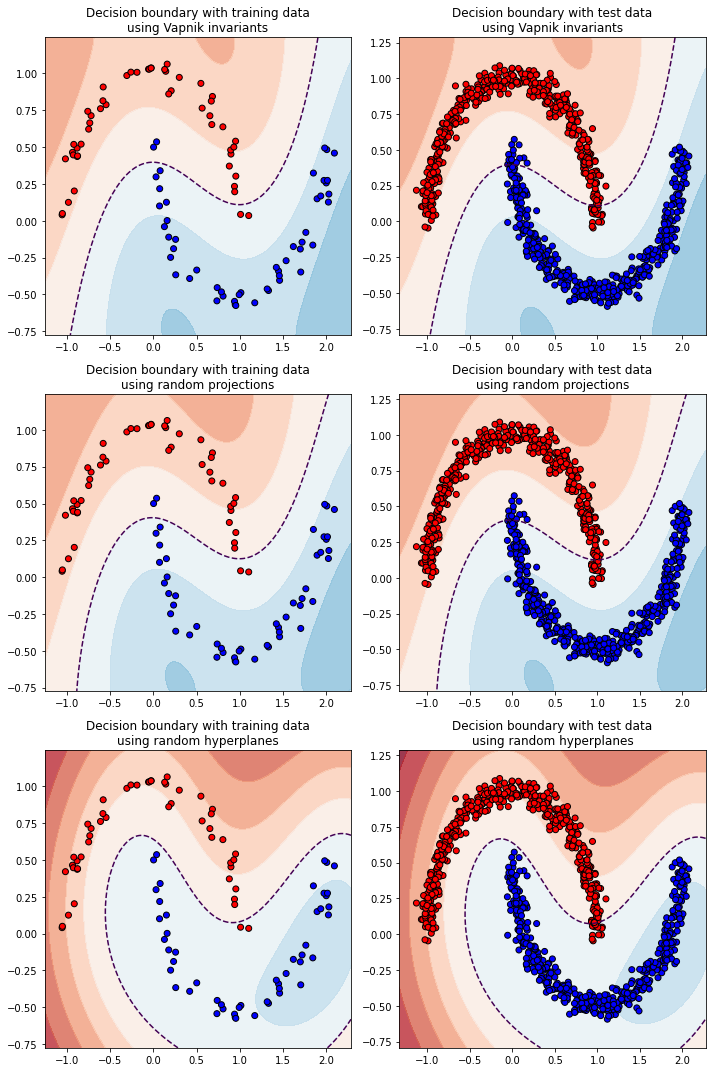

In [77]:
seeds = [42, 47, 194, 8923, 293, 7892, 9123, 923184, 83291, 193927]
invariant_types = [InvariantTypes.VAPNIK, InvariantTypes.PROJECTION, InvariantTypes.HYPERPLANE]

n_invariants_circles = run_experiment_dataset(datasets[0], seeds, invariant_types, 'circles_decision_boundaries.png')
n_invariants_moons = run_experiment_dataset(datasets[1], seeds, invariant_types, 'moons_decision_boundaries.png')

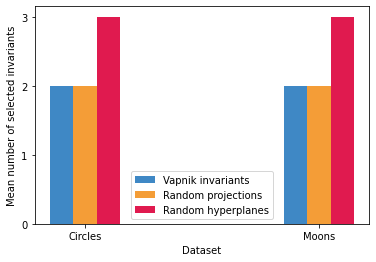

In [78]:
vapnik_results = [n_invariants_circles[InvariantTypes.VAPNIK], n_invariants_moons[InvariantTypes.VAPNIK]]
proj_results = [n_invariants_circles[InvariantTypes.PROJECTION], n_invariants_moons[InvariantTypes.PROJECTION]]
hyp_results = [n_invariants_circles[InvariantTypes.HYPERPLANE], n_invariants_moons[InvariantTypes.HYPERPLANE]]

width = 0.1

X = ["Circles", "Moons"]
X_axis = np.arange(len(X))

plt.bar(X_axis - width, vapnik_results, width=width, label="Vapnik invariants", color="#3f88c5")
plt.bar(X_axis, proj_results, width=width, label="Random projections", color="#f49d37")
plt.bar(X_axis + width, hyp_results, width=width, label="Random hyperplanes", color="#e01a4f")
  
plt.xticks(X_axis, X)
plt.yticks(np.arange(0, 4))

plt.xlabel('Dataset')
plt.ylabel('Mean number of selected invariants')
plt.legend()


plt.savefig("num_selected_invariants.png")
plt.show()

In [83]:
from collections import Counter

def run_large_experiment(dataset, seeds, invariant_types, title=''):
    X, y = dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=0.1,
        stratify=y,
        random_state=47,
    )
    
    n_selected = {
        InvariantTypes.PROJECTION: [],
        InvariantTypes.HYPERPLANE: [],
        InvariantTypes.VAPNIK: [],
    }

    first_selected = {
        InvariantTypes.PROJECTION: [],
        InvariantTypes.HYPERPLANE: [],
        InvariantTypes.VAPNIK: [],
    }
    
    max_selected = {
        InvariantTypes.PROJECTION: [],
        InvariantTypes.HYPERPLANE: [],
        InvariantTypes.VAPNIK: [],
    }
    
    accuracies = []

    for seed in seeds:
        clf = SVMRandomInvariants(num_invariants=50, invariant_type=InvariantTypes.ALL, random_state=seed)
        clf.fit(X_train, y_train)
        invariants = clf.invariants
        
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        
        selected_counts = Counter(invariant['type'] for invariant in invariants)
        
        first_invariants = invariants[:10]
        first_counts = Counter(invariant['type'] for invariant in first_invariants)
        
        max_first = sorted(invariants, key=lambda x: -x['T_value'])[:10]
        max_counts = Counter(invariant['type'] for invariant in max_first)
        
        for type_key in n_selected.keys():
            n_selected[type_key].append(selected_counts[type_key] if type_key in selected_counts.keys() else 0)
            first_selected[type_key].append(first_counts[type_key] if type_key in first_counts.keys() else 0)
            max_selected[type_key].append(max_counts[type_key] if type_key in max_counts.keys() else 0)

    print(f"\n\n------------ {title} ------------\n\n")
    print("\n----- Accuracy information ------")
    print("\n\nAccuracies: ", accuracies)
    print("Mean accuracy: ", np.mean(accuracies))
    print("Min accuracy: ", np.min(accuracies))
    print("Max accuracy: ", np.max(accuracies))
    print("Std: ", np.std(accuracies))

    print("\n----- Invariants information ------")

    for type_key in n_selected.keys():
        print("\n\nInformation for invariant type ", type_key)
        print("Number of times selected: ", n_selected[type_key])
        print("Mean number of times selected: ", np.mean(n_selected[type_key]))
        print("Number of times selected among the first 10: ", first_selected[type_key])
        print("Mean number of times selected among the first 10: ", np.round(np.mean(first_selected[type_key])))
        print("Number of times selected with the maximum values: ", max_selected[type_key])
        print("Mean number of times selected with the maximum values: ", np.round(np.mean(max_selected[type_key])))
    
    return n_selected, first_selected, max_selected

In [84]:
circles_n_selected, circles_first_selected, circles_max_selected = run_large_experiment(dataset, seeds, invariant_types, 'Circles experiments')
moons_n_selected, moons_first_selected, moons_max_selected = run_large_experiment(dataset, seeds, invariant_types, 'Moons experiments')



------------ Circles experiments ------------



----- Accuracy information ------


Accuracies:  [0.9866666666666667, 0.9966666666666667, 1.0, 0.9811111111111112, 0.9766666666666667, 0.99, 0.9777777777777777, 0.9855555555555555, 0.9888888888888889, 0.99]
Mean accuracy:  0.9873333333333333
Min accuracy:  0.9766666666666667
Max accuracy:  1.0
Std:  0.007152656417524928

----- Invariants information ------


Information for invariant type  InvariantTypes.PROJECTION
Number of times selected:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 1]
Mean number of times selected:  1.7
Number of times selected among the first 10:  [2, 1, 1, 1, 2, 1, 1, 1, 2, 1]
Mean number of times selected among the first 10:  1.0
Number of times selected with the maximum values:  [2, 1, 1, 1, 2, 1, 1, 1, 2, 1]
Mean number of times selected with the maximum values:  1.0


Information for invariant type  InvariantTypes.HYPERPLANE
Number of times selected:  [48, 48, 48, 48, 48, 49, 49, 48, 48, 49]
Mean number of times selected:  48

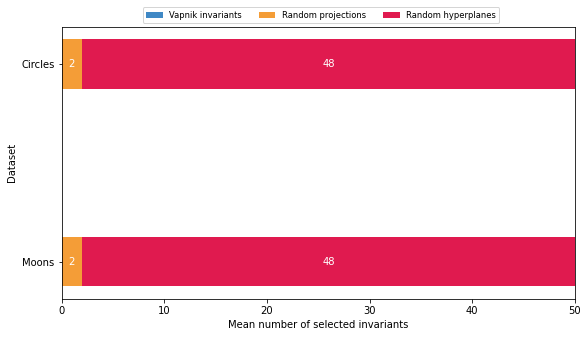

In [121]:
# Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html

total_selected_means = {
    'Circles': [
        np.round(np.mean(circles_n_selected[InvariantTypes.VAPNIK])),
        np.round(np.mean(circles_n_selected[InvariantTypes.PROJECTION])),
        np.round(np.mean(circles_n_selected[InvariantTypes.HYPERPLANE])),
    ],
    'Moons': [
        np.round(np.mean(moons_n_selected[InvariantTypes.VAPNIK])),
        np.round(np.mean(moons_n_selected[InvariantTypes.PROJECTION])),
        np.round(np.mean(moons_n_selected[InvariantTypes.HYPERPLANE])),
    ], 
}

labels = list(total_selected_means.keys())
data = np.array(list(total_selected_means.values()))
data_cum = data.cumsum(axis=1)

category_colors = ["#3f88c5", "#f49d37", "#e01a4f"]
category_names = ["Vapnik invariants", "Random projections", "Random hyperplanes"]

fig, ax = plt.subplots(figsize=(9.2, 5))
ax.invert_yaxis()
ax.xaxis.set_visible(True)
ax.set_xlim(0, np.sum(data, axis=1).max())
ax.set_ylabel('Dataset')

ax.set_xlabel('Mean number of selected invariants')

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.25,
                    label=colname, color=color)

    if np.all(widths > 0.0):
        text_color = 'white'
        ax.bar_label(rects, label_type='center', color=text_color)
ax.legend(ncol=len(category_names), bbox_to_anchor=(0.15, 1),
          loc='lower left', fontsize='small')

plt.savefig("mean_num_selected_invariants.png")
plt.show()

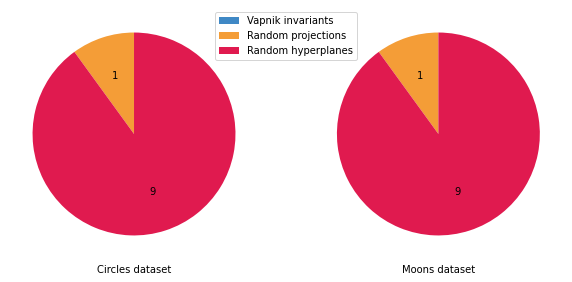

In [165]:
first_selected_means = {
    'Circles': [
        np.round(np.mean(circles_first_selected[InvariantTypes.VAPNIK])),
        np.round(np.mean(circles_first_selected[InvariantTypes.PROJECTION])),
        np.round(np.mean(circles_first_selected[InvariantTypes.HYPERPLANE])),
    ],
    'Moons': [
        np.round(np.mean(moons_first_selected[InvariantTypes.VAPNIK])),
        np.round(np.mean(moons_first_selected[InvariantTypes.PROJECTION])),
        np.round(np.mean(moons_first_selected[InvariantTypes.HYPERPLANE])),
    ], 
}

first_selected_means

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

autopct_func = lambda p: f'{p * 10 / 100:.0f}' if p > 0 else ''

ax1.pie(first_selected_means['Circles'], colors=category_colors, autopct=autopct_func, startangle=90)
ax2.pie(first_selected_means['Moons'], colors=category_colors, autopct=autopct_func, startangle=90)

ax1.set_xlabel('Circles dataset')
ax2.set_xlabel('Moons dataset')

plt.legend(labels=category_names, loc="upper left", bbox_to_anchor=(-0.4, 1))

plt.savefig("mean_first_selected.png")
plt.show()
